<a href="https://colab.research.google.com/github/mahendrakevin/NLP-Project/blob/master/Deep%20Learning%20Twitter%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 | Klasifikasi Natural Language Processing pada Data Twitter

## Dalam Notebook ini akan menjelaskan beberapa hal: 

1. Klasifikasi Text (Natural Language Processing) dengan algoritma Gate Recurrent Unit, Bidirectional Long Short-Term Memory, Convolutional Neural Network

2. Dataset yang digunakan https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/blob/master/Twitter_Emotion_Dataset.csv, yang berisi data postingan pada twitter dengan 5 label

3. Cleaning & Preprocessing Data:
.
- Menghilangkan record yang memiliki nilai kosong / terduplikat
- Menghilangkan karakter-karakter kata yang dianggap tidak penting dan menghilangkan karakter spesial (Punctuation)
- Mengubah semua kata menjadi lowercase
- Mengubah kata-kata yang singkat dengan replacing data dari dictionary https://github.com/riochr17/Analisis-Sentimen-ID/blob/master/kamus/kbba.txt
- Menghilangkan kata-kata yg tidak penting (stopword)
- Mengembalikan kata-kata kedalam bentuk asli nya nya (Stemming dengan Sastrawi)
- Menghapus kata yang memiliki kurang dari 3 karakter
.

#### 1. Import Library dan Dependencies

In [2]:
!pip install sastrawi

     |████████████████████████████████| 215kB 3.4MB/s 


In [3]:
import nltk
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import re
import itertools
import string
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<h2 id="understanding_data">Understanding the Data</h2>

### `Twitter_Emotion_Dataset.csv`:
Saya sudah download dataset, **`Twitter_Emotion_Dataset.csv`**, dimana berisi data postingan di Twitter kemudian 5 label yang berbeda. [Dataset source](https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/blob/master/Twitter_Emotion_Dataset.csv)

- **label** e.g. Anger
- **tweet** e.g. soal jalan jatibaru polisi gertak gubernur ema...


In [4]:
df_tweets = pd.read_csv("Twitter_Emotion_Dataset.csv", encoding = "ISO-8859-1")
df_tweets.isna().sum()

label    0
tweet    0
dtype: int64

#### 2. Menghapus data yang terduplikat

In [5]:
df_tweets = df_tweets.drop_duplicates()
df_tweets.duplicated().sum()

0

#### 3. Membuat fungsi untuk melakukan preprocessing dataset

In [6]:
factory = StopWordRemoverFactory()
sw = factory.get_stop_words()

def remove_tweet_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"").replace('user', "").replace('-', " ").replace(',', " ")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text.replace("http://", " ").replace("https://", " ")
                
def remove_number(text):
    return  re.sub(r"\d+", "", text)

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

def word_tokenize_wrapper(text):
    return word_tokenize(text)


def normalizing_words(review):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(review))

def preprocess_tweet(tweet):
    tweet.lower()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output = stemmer.stem(tweet)
    
    return output

#### 4. Loading Data Dictionary untuk mengubah kata-kata singkat

In [7]:
d = {}
with open("kbba.txt") as f:
    for line in f:
        (key, val) = line.split('\t')
        d[key] = val
        d[key] = re.sub(r'\n', '', d[key])

def process(ss):
    for line in ss:
        da = ''.join(d.get(word, word) for word in re.split( '(\W+)', line))
        return da

#### 5. Code dibawah adalah proses replacing kata-kata singkat pada dataset menggunakan data dictionary yang sudah di load sebelumnya

In [8]:
df_tweets['tweet'] = df_tweets['tweet'].str.replace('[...…]','').str.split().apply(lambda x: ' '.join([d.get(e, e) for e in x]))

#### 6. Melakukan text preprocessing dengan memanggil fungsi yang sudah dibuat sebelumnya

In [9]:
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_tweet_special)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_number)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_punctuation)
df_tweets['tweet'] = df_tweets['tweet'].apply(stopwords)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_LT)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_multiple)

In [10]:
df_tweets.head()

,label,tweet
0,anger,soal jalan jatibaru polisi gertak gubernur ema...
1,anger,sesama cewek lho kayaknya harusnya lebih rasai...
2,happy,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jln jatibaru bagian wilayah tn abangpengaturan...
4,happy,sharing pengalaman aja kemarin jam batalin tik...


#### 7. Stemming Data Menggunakan Sastrawi
Untuk menghemat waktu dalam proses stemming data menggunakan sastrawi, maka saya export kedalam format csv untuk digunakan dikemudian hari tanpa harus melakukan stemming kembali

In [11]:
# df_tweets['tweet_norm'] = df_tweets['Tweet'].apply(preprocess_tweet)
# df_tweets.to_csv('twit_ira.csv')

#### 8. Load Dataset yang sudah di preposs

In [12]:
df_tweets = pd.read_csv('tweets_preprocessed.csv')
df_tweets.head()

,Unnamed: 0,label,tweet,tweet_norm
0,0,anger,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...
1,1,anger,sesama cewek lho kayaknya harusnya lebih rasai...,sama cewek lho kayak harus lebih rasain lah si...
2,2,happy,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek bu hj amad foto google sengaj...
3,3,anger,jalan jatibaru bagian wilayah tn abangpengatur...,jalan jatibaru bagi wilayah tn abangpengaturan...
4,4,happy,sharing pengalaman kemarin jam batalin tiket s...,sharing alam kemarin jam batalin tiket stasiun...


#### 9. Lakukan proses replacing kata-kata singkat dari data dictionary kembali untuk memastikan  tidak ada kata yang tersingkat

In [13]:
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].str.replace('[...…]','').str.split().apply(lambda x: ' '.join([d.get(e, e) for e in x]))

In [14]:
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].astype(str)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(remove_tweet_special)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(remove_number)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(remove_punctuation)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(stopwords)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(remove_whitespace_LT)
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].apply(remove_whitespace_multiple)

#### 10. Membuat fungsi Clean_length dan convert_to_string
Bertujuan untuk menghapus kata yang memiliki kurang dari 4 karakter

In [15]:
def Clean_length(token):
    return [i for i in token if len(i) > 3]
def convert_to_string(listReview):
    return ' '.join(listReview)

df_tweets['tweet_norm2'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(Clean_length)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(convert_to_string)

### Visualisasi kata yang sering muncul dengan wordcloud

#### 11. Import library worcloud

In [16]:
from wordcloud import WordCloud

In [17]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
token_vocab = df_tweets['tweet_norm2'].apply(word_tokenize_wrapper)
matrix = vectorizer.fit_transform([x for x in np.array(token_vocab)])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 1012


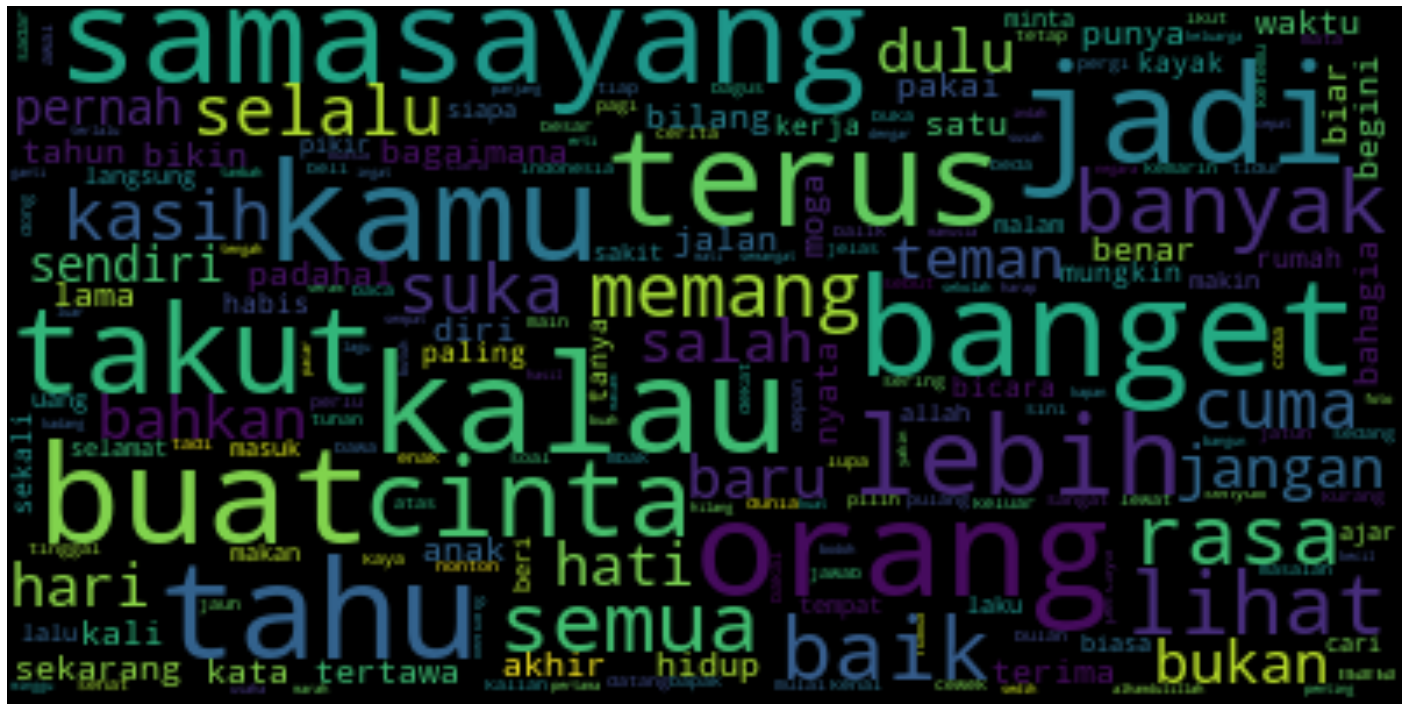

In [18]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']    
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True))

#### 12. Menghitung jumlah kata unik pada dataset

In [19]:
unique_string = set()
for x in df_tweets['tweet_norm2']:
    for y in x.split():
        unique_string.add(y)
        
len(unique_string)

11940

#### 13. Import library Deep Learning Keras & sklearn

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import initializers
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional, GRU
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.layers.merge import Concatenate
from keras.layers import GlobalMaxPool1D
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

In [61]:
# df_tweets_onehot = pd.get_dummies(df_tweets, columns=['label'])
# df_tweets_onehot.head()

#### 15. Feature engineering

In [62]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
X = []
sentences = list(df_tweets["tweet_norm2"])
for sen in sentences:
    X.append(preprocess_text(sen))

label = df_tweets['label_id'].values
y = to_categorical(label, num_classes = leng)

#### 16. Konversi label ke numerikal

In [63]:
df_tweets['label_id'] = df_tweets['label'].factorize()[0]
from io import StringIO
kategori_id_data = df_tweets[['label', 'label_id']].drop_duplicates().sort_values('label_id')
kategori_to_id = dict(kategori_id_data.values)
id_to_kategori = dict(kategori_id_data[['label_id', 'label']].values)

In [64]:
id_to_kategori

{0: 'anger', 1: 'happy', 2: 'sadness', 3: 'love', 4: 'fear'}

In [65]:
leng = kategori_id_data.label_id.values
leng = len (leng)
leng

5

#### 17. Melakukan splitting data untuk digunakan sebagai training dan testing dengan ukuran test 0.01% atau sekitar 44 record

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)

In [68]:
# First output
y1_train = y_train[["label_anger"]].values
y1_test =  y_test[["label_anger"]].values

# Second output
y2_train = y_train[["label_fear"]].values
y2_test =  y_test[["label_fear"]].values

# Third output
y3_train = y_train[["label_happy"]].values
y3_test =  y_test[["label_happy"]].values

# Fourth output
y4_train = y_train[["label_love"]].values
y4_test =  y_test[["label_love"]].values

# Fifth output
y5_train = y_train[["label_sadness"]].values
y5_test =  y_test[["label_sadness"]].values


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: ignored

#### 18. Mengubah teks menjadi token dan konversi menjadi sequence

In [69]:
num_words = 20000
emb_size = 128
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(sentences))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### 19. Mendefinisikan fungsi model deep learning GRU, Bi-LSTM, CNN, dan fungsi evaluasi model

In [127]:
def gru_model():
    inp = Input(shape = (maxlen, ))
    layer = Embedding(vocab_size, emb_size, input_length=maxlen)(inp)
    layer = SpatialDropout1D(0.2)(layer)
    layer = Bidirectional(GRU(128))(layer)
    layer = Dense(128, activation = 'relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(5, activation = 'sigmoid')(layer)
    model1 = Model(inputs = inp, outputs = layer)
    model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model1

def lstm_model():
    inp = Input(shape = (maxlen, ))
    layer = Embedding(vocab_size, emb_size)(inp)
    layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.1))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(100, activation = 'relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(leng, activation = 'sigmoid')(layer)
    model2 = Model(inputs = inp, outputs = layer)
    model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model2

def cnn_model():
    inp = Input(shape = (maxlen, ))
    layer = Embedding(input_dim = vocab_size, output_dim = 128, input_length = maxlen)(inp)
    layer = Conv1D(128, 7, activation='relu',padding='same')(layer)
    layer = MaxPooling1D()(layer)
    layer = Conv1D(256, 5, activation='relu',padding='same')(layer)
    layer = MaxPooling1D()(layer)
    layer = Conv1D(512, 3, activation='relu',padding='same')(layer)
    layer = MaxPooling1D()(layer)
    layer = Flatten()(layer)
    layer = Dense(128, activation='sigmoid')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(leng, activation='softmax')(layer)
    model3 = Model(inputs = inp, outputs = layer)
    model3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model3.summary()
    
    return model3

def evaluation(model, X, Y):
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    rounded_labels=np.argmax(Y, axis=1)
    Y_act = rounded_labels
    
    acc = accuracy_score(Y_act, Y_pred_class)
    
    return acc

In [128]:
gru_model = gru_model()
gru_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 200, 128)          1528448   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 200, 128)          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 256)               198144    
_________________________________________________________________
dense_48 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 5)               

In [129]:
lstm_model = lstm_model()
lstm_model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 200, 128)          1528448   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 200, 100)          71600     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)             

In [130]:
cnn_model = cnn_model()
cnn_model.summary()

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 200, 128)          1528448   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 128)          114816    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 100, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 256)          164096    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 50, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 50, 512)         

#### 20. Plot model deep learning (layer model)

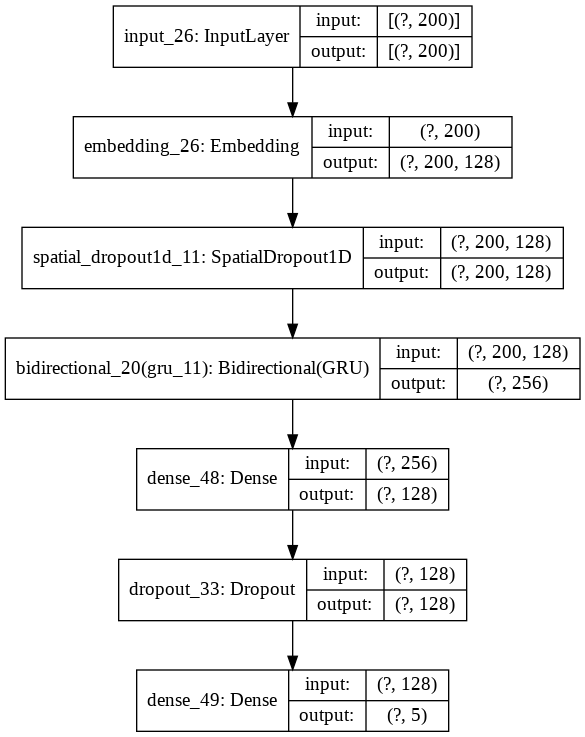

In [131]:
from keras.utils import plot_model
plot_model(gru_model, to_file='model_gru.png', show_shapes=True, show_layer_names=True)

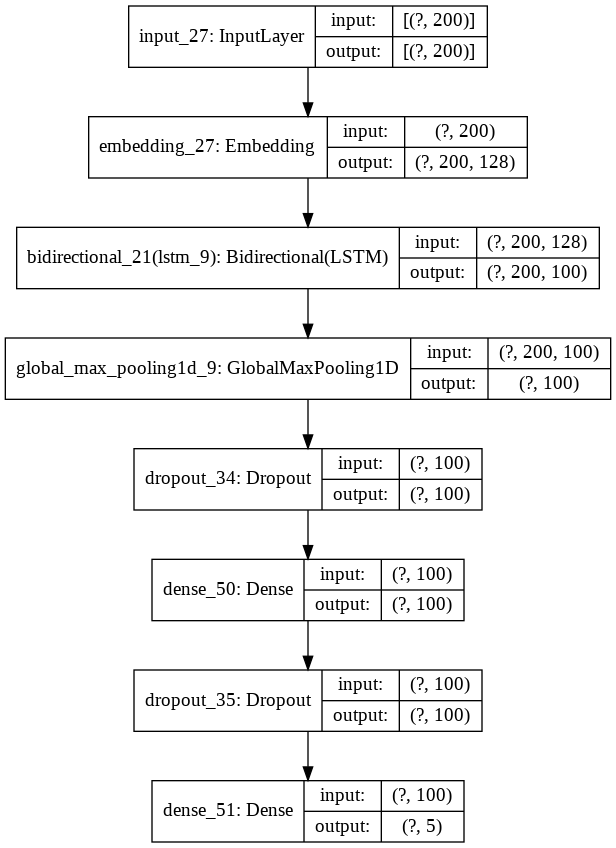

In [132]:
plot_model(lstm_model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

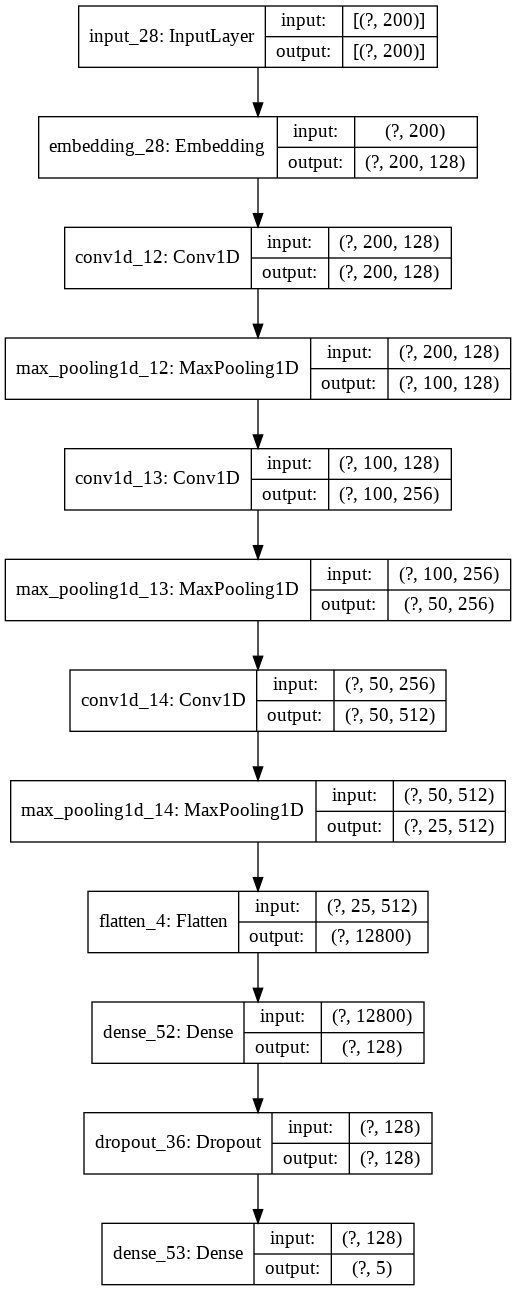

In [133]:
plot_model(cnn_model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

#### 21. Deklarasi variabel checkpoint dan early stopping untuk mendapatkan model training yang tidak overfitting maupun underfitting

In [134]:
file_path = 'save_best'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

#### 22. Training model dengan epoch 20x

In [135]:
gru = gru_model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1)

Epoch 1/10
123/123 [==============================] - 50s 408ms/step - loss: 1.4908 - accuracy: 0.3130 - val_loss: 1.2811 - val_accuracy: 0.4368
Epoch 2/10
123/123 [==============================] - 49s 395ms/step - loss: 0.9703 - accuracy: 0.6193 - val_loss: 1.0270 - val_accuracy: 0.5908
Epoch 3/10
123/123 [==============================] - 49s 395ms/step - loss: 0.5679 - accuracy: 0.7868 - val_loss: 1.1694 - val_accuracy: 0.5839
Epoch 4/10
123/123 [==============================] - 49s 398ms/step - loss: 0.3171 - accuracy: 0.8957 - val_loss: 1.3953 - val_accuracy: 0.5770
Epoch 5/10
123/123 [==============================] - 50s 406ms/step - loss: 0.1569 - accuracy: 0.9496 - val_loss: 1.7616 - val_accuracy: 0.5609
Epoch 6/10
123/123 [==============================] - 49s 398ms/step - loss: 0.0899 - accuracy: 0.9742 - val_loss: 1.9085 - val_accuracy: 0.5931
Epoch 7/10
123/123 [==============================] - 49s 395ms/step - loss: 0.0728 - accuracy: 0.9778 - val_loss: 2.0297 - val_ac

In [136]:
lstm = lstm_model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1)

Epoch 1/10
123/123 [==============================] - 55s 448ms/step - loss: 1.5392 - accuracy: 0.2938 - val_loss: 1.3016 - val_accuracy: 0.4713
Epoch 2/10
123/123 [==============================] - 54s 443ms/step - loss: 1.0209 - accuracy: 0.6062 - val_loss: 1.0181 - val_accuracy: 0.5862
Epoch 3/10
123/123 [==============================] - 54s 443ms/step - loss: 0.5890 - accuracy: 0.7929 - val_loss: 1.0916 - val_accuracy: 0.6046
Epoch 4/10
123/123 [==============================] - 54s 443ms/step - loss: 0.2670 - accuracy: 0.9174 - val_loss: 1.2809 - val_accuracy: 0.6161
Epoch 5/10
123/123 [==============================] - 55s 445ms/step - loss: 0.1130 - accuracy: 0.9752 - val_loss: 1.4967 - val_accuracy: 0.6322
Epoch 6/10
123/123 [==============================] - 54s 441ms/step - loss: 0.0671 - accuracy: 0.9818 - val_loss: 1.5518 - val_accuracy: 0.6253
Epoch 7/10
123/123 [==============================] - 55s 447ms/step - loss: 0.0373 - accuracy: 0.9898 - val_loss: 1.9132 - val_ac

In [137]:
cnn = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1)

Epoch 1/10
123/123 [==============================] - 40s 324ms/step - loss: 1.4454 - accuracy: 0.3465 - val_loss: 1.1458 - val_accuracy: 0.5609
Epoch 2/10
123/123 [==============================] - 39s 320ms/step - loss: 0.9971 - accuracy: 0.5988 - val_loss: 1.1220 - val_accuracy: 0.5609
Epoch 3/10
123/123 [==============================] - 39s 320ms/step - loss: 0.6094 - accuracy: 0.7806 - val_loss: 1.2124 - val_accuracy: 0.5609
Epoch 4/10
123/123 [==============================] - 40s 325ms/step - loss: 0.3505 - accuracy: 0.8791 - val_loss: 1.4594 - val_accuracy: 0.5448
Epoch 5/10
123/123 [==============================] - 39s 320ms/step - loss: 0.1838 - accuracy: 0.9445 - val_loss: 1.6735 - val_accuracy: 0.5609
Epoch 6/10
123/123 [==============================] - 39s 321ms/step - loss: 0.0994 - accuracy: 0.9765 - val_loss: 1.8060 - val_accuracy: 0.5885
Epoch 7/10
123/123 [==============================] - 39s 320ms/step - loss: 0.0717 - accuracy: 0.9813 - val_loss: 2.0148 - val_ac

#### 23. Menghitung dan plotting akurasi/loss model

In [138]:
acc_gru = evaluation(gru_model, X_test, y_test)
acc_lstm = evaluation(lstm_model, X_test, y_test)
acc_cnn = evaluation(cnn_model, X_test, y_test)

In [139]:
print("Accuracy Gate Recurrent Unit Model: %.2f" % (acc_gru*100), "%")
print("Accuracy Bidirectional LSTM Model: %.2f" % (acc_lstm*100), "%")
print("Accuracy Convolutional Neural Network Model: %.2f" % (acc_cnn*100), "%")

Accuracy Gate Recurrent Unit Model: 59.09 %
Accuracy Bidirectional LSTM Model: 54.55 %
Accuracy Convolutional Neural Network Model: 45.45 %


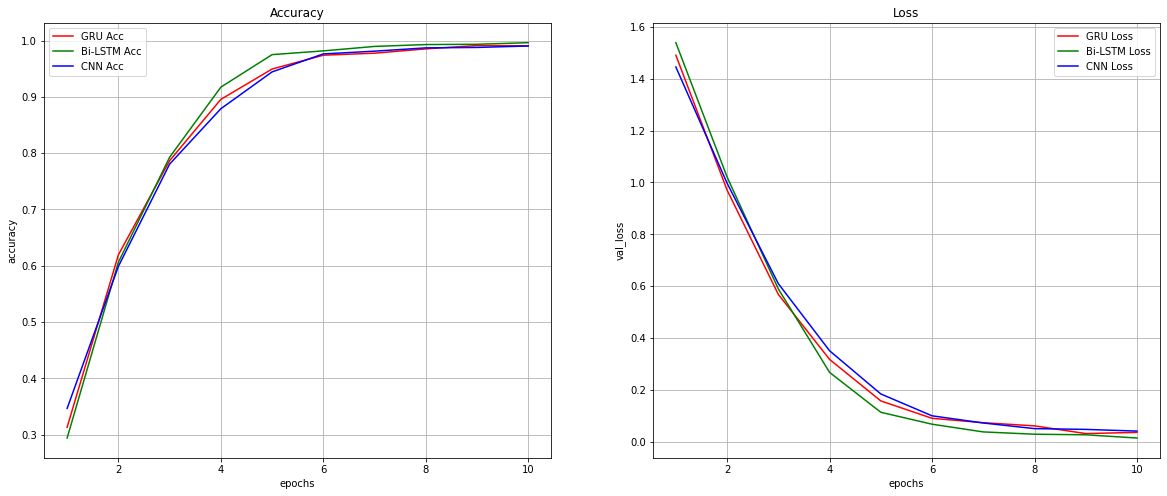

In [145]:
def plot_history(model1, model2, model3):
    model1_acc = model1.history['accuracy']
    model1_loss = model1.history['loss']
    model2_acc = model2.history['accuracy']
    model2_loss = model2.history['loss']
    model3_acc = model3.history['accuracy']
    model3_loss = model3.history['loss']
    x = range(1, len(model1_acc) + 1)
    y = range(1, len(model2_acc) + 1)
    z = range(1, len(model3_acc) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, model1_acc, 'r', label='GRU Acc')
    plt.plot(y, model2_acc, 'g', label='Bi-LSTM Acc')
    plt.plot(z, model3_acc, 'b', label='CNN Acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, model1_loss, 'r', label='GRU Loss')
    plt.plot(y, model2_loss, 'g', label='Bi-LSTM Loss')
    plt.plot(z, model3_loss, 'b', label='CNN Loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('val_loss')
    plt.grid()
    plt.title('Loss')
plot_history(gru, lstm, cnn)

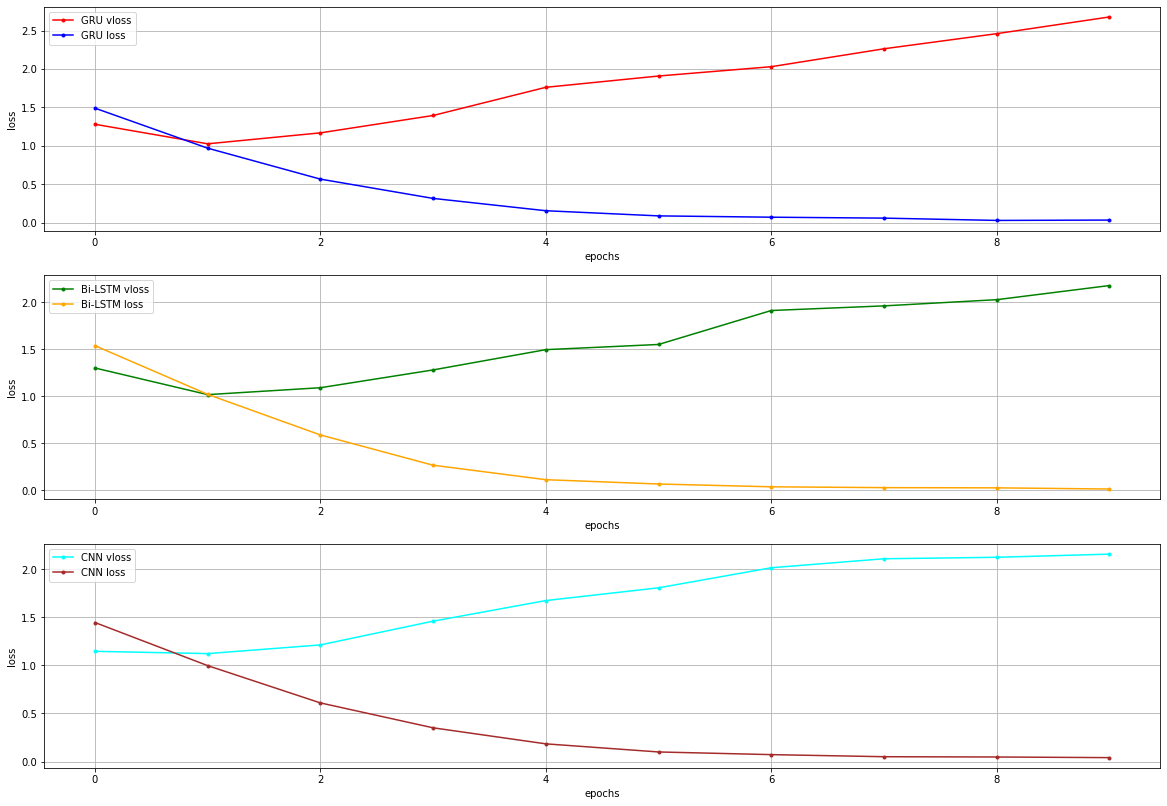

In [165]:
import matplotlib.gridspec as gridspec
gru_vloss = gru.history['val_loss']
gru_loss = gru.history['loss']
lstm_vloss = lstm.history['val_loss']
lstm_loss = lstm.history['loss']
cnn_vloss = cnn.history['val_loss']
cnn_loss = cnn.history['loss']

x_len = np.arange(len(gru_loss))
y_len = np.arange(len(lstm_loss))
z_len = np.arange(len(cnn_loss))

gs = gridspec.GridSpec(3, 1)
plt.figure(figsize=(20, 14))
plt.subplot(gs[0, 0])
plt.plot(x_len, gru_vloss, marker='.', c='red', label='GRU vloss')
plt.plot(x_len, gru_loss, marker='.', c='blue', label='GRU loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.subplot(gs[1, 0])
plt.plot(y_len, lstm_vloss, marker='.', c='green', label='Bi-LSTM vloss')
plt.plot(y_len, lstm_loss, marker='.', c='orange', label='Bi-LSTM loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.subplot(gs[2, 0])
plt.plot(z_len, cnn_vloss, marker='.', c='cyan', label='CNN vloss')
plt.plot(z_len, cnn_loss, marker='.', c='brown', label='CNN loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

#### 24. Menyimpan Model

In [166]:
gru_model.save('Deep Model/model_Deep_GRU.h5')
lstm_model.save('Deep Model/model_Deep_BiLSTM.h5')
cnn_model.save('Deep Model/model_Deep_CNN.h5')

In [167]:
model = load_model('Deep Model/model_Deep_BiLSTM.h5')

NameError: ignored

#### 25. Membuat test set dan testing dengan data baru

In [168]:
test =['hari ini sangat indah',
       'kok kamu jelek bgt sih',
       'ada berita duka yang menyedihkan',
       'bagaimana kabar hari ini?',
       'semua baik-baik2 saja kan',
      'kenapa kamu sebodoh itu?',
      'kabar jogja hari ini',
      'kapan corona nya pergi',
      'aku takut dengan corona',
      'kamu sayang sama aku?',
      'aku sangat bahagia hari ini']

In [169]:
text1 = tokenizer.texts_to_sequences(test)
text1 = pad_sequences(text1, maxlen=maxlen)

In [172]:
pred_gru = gru_model.predict(text1)
label1 = np.argmax(pred_gru, axis = 1) 

pred_lstm = lstm_model.predict(text1)
label2 = np.argmax(pred_lstm, axis = 1) 

pred_cnn = cnn_model.predict(text1)
label3 = np.argmax(pred_cnn, axis = 1) 

In [173]:
label =[]
kal = []
probab = []
for unlabeled, label1 in zip(test, label1):
    print('"{}"'.format(unlabeled))
    u = unlabeled
    l = id_to_kategori[label1]
    label.append(l)
    kal.append(u)
    
    print("  - Prediksi: '{}'".format(id_to_kategori[label1]))
    print("")

"hari ini sangat indah"
  - Prediksi: 'anger'

"kok kamu jelek bgt sih"
  - Prediksi: 'sadness'

"ada berita duka yang menyedihkan"
  - Prediksi: 'anger'

"bagaimana kabar hari ini?"
  - Prediksi: 'anger'

"semua baik-baik2 saja kan"
  - Prediksi: 'anger'

"kenapa kamu sebodoh itu?"
  - Prediksi: 'sadness'

"kabar jogja hari ini"
  - Prediksi: 'anger'

"kapan corona nya pergi"
  - Prediksi: 'anger'

"aku takut dengan corona"
  - Prediksi: 'sadness'

"kamu sayang sama aku?"
  - Prediksi: 'anger'

"aku sangat bahagia hari ini"
  - Prediksi: 'anger'



In [174]:
label =[]
kal = []
probab = []
for unlabeled, label2 in zip(test, label2):
    print('"{}"'.format(unlabeled))
    u = unlabeled
    l = id_to_kategori[label2]
    label.append(l)
    kal.append(u)
    
    print("  - Prediksi: '{}'".format(id_to_kategori[label2]))
    print("")

"hari ini sangat indah"
  - Prediksi: 'happy'

"kok kamu jelek bgt sih"
  - Prediksi: 'love'

"ada berita duka yang menyedihkan"
  - Prediksi: 'sadness'

"bagaimana kabar hari ini?"
  - Prediksi: 'sadness'

"semua baik-baik2 saja kan"
  - Prediksi: 'sadness'

"kenapa kamu sebodoh itu?"
  - Prediksi: 'happy'

"kabar jogja hari ini"
  - Prediksi: 'sadness'

"kapan corona nya pergi"
  - Prediksi: 'sadness'

"aku takut dengan corona"
  - Prediksi: 'fear'

"kamu sayang sama aku?"
  - Prediksi: 'love'

"aku sangat bahagia hari ini"
  - Prediksi: 'happy'



In [175]:
label =[]
kal = []
probab = []
for unlabeled, label3 in zip(test, label3):
    print('"{}"'.format(unlabeled))
    u = unlabeled
    l = id_to_kategori[label3]
    label.append(l)
    kal.append(u)
    
    print("  - Prediksi: '{}'".format(id_to_kategori[label3]))
    print("")

"hari ini sangat indah"
  - Prediksi: 'happy'

"kok kamu jelek bgt sih"
  - Prediksi: 'happy'

"ada berita duka yang menyedihkan"
  - Prediksi: 'happy'

"bagaimana kabar hari ini?"
  - Prediksi: 'happy'

"semua baik-baik2 saja kan"
  - Prediksi: 'happy'

"kenapa kamu sebodoh itu?"
  - Prediksi: 'happy'

"kabar jogja hari ini"
  - Prediksi: 'happy'

"kapan corona nya pergi"
  - Prediksi: 'happy'

"aku takut dengan corona"
  - Prediksi: 'happy'

"kamu sayang sama aku?"
  - Prediksi: 'happy'

"aku sangat bahagia hari ini"
  - Prediksi: 'happy'

